In [2]:

!pip install --upgrade kaleido


In [3]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [14]:
# ─── Cell 1: Imports & folders ───
import os
import pandas as pd
import numpy as np
import plotly.express as px

# Make sure our images folder lives at the project root
os.makedirs("../images", exist_ok=True)



In [20]:

# Load the CSV
df = pd.read_csv(
    "data/close_prices.csv",
    index_col="Date",
    parse_dates=True
)

# 1) Back-fill any leading NaNs (some tickers start later)
# 2) Forward-fill to cover any gaps
# 3) Drop any rows still containing NaN
df = df.bfill().ffill().dropna()

print("✅ Cleaned DF shape:", df.shape)
df.head()


✅ Cleaned DF shape: (270, 5)


,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2024-07-01,216.750000,197.199997,182.990005,456.730011,209.860001
2024-07-02,220.270004,200.000000,185.240005,459.279999,231.259995
2024-07-03,221.550003,197.589996,185.820007,460.769989,246.389999
2024-07-05,226.339996,200.000000,190.600006,467.559998,251.520004
2024-07-08,227.820007,199.289993,189.029999,466.239990,252.940002


Annual volatility (%) for each ticker:
 AAPL     31.137665
AMZN     33.595590
GOOGL    31.259647
MSFT     24.698028
TSLA     73.355964
dtype: float64


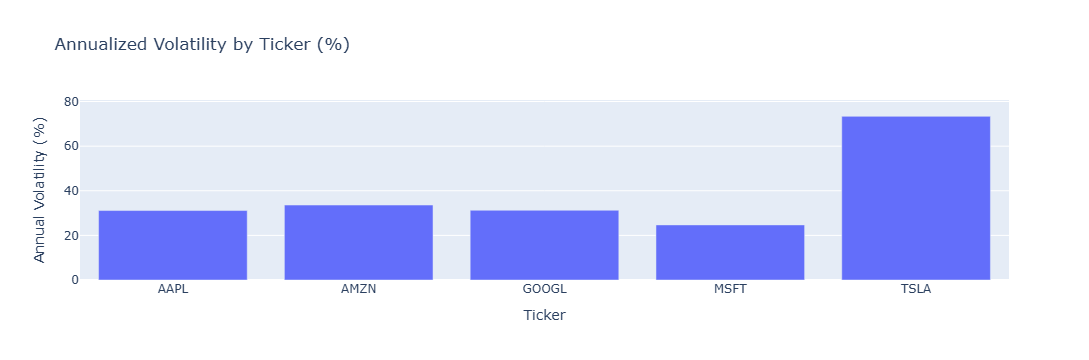

✅ Saved images/volatility_pct.png


In [22]:

# Compute daily returns (no pad-fill) and annualized volatility
returns = df.pct_change(fill_method=None).dropna()
vol = returns.std() * np.sqrt(252)    # annualized vol
vol_pct = vol * 100                    # convert to percent

print("Annual volatility (%) for each ticker:\n", vol_pct)

# Plot as a bar chart
fig_vol = px.bar(
    x=vol_pct.index, y=vol_pct.values,
    labels={"x":"Ticker", "y":"Annual Volatility (%)"},
    title="Annualized Volatility by Ticker (%)"
)
# Zoom y-axis to just above your max
fig_vol.update_yaxes(range=[0, vol_pct.max()*1.1])

# Save and show
fig_vol.write_image("images/volatility_pct.png", width=600, height=400)
fig_vol.show()
print("✅ Saved images/volatility_pct.png")


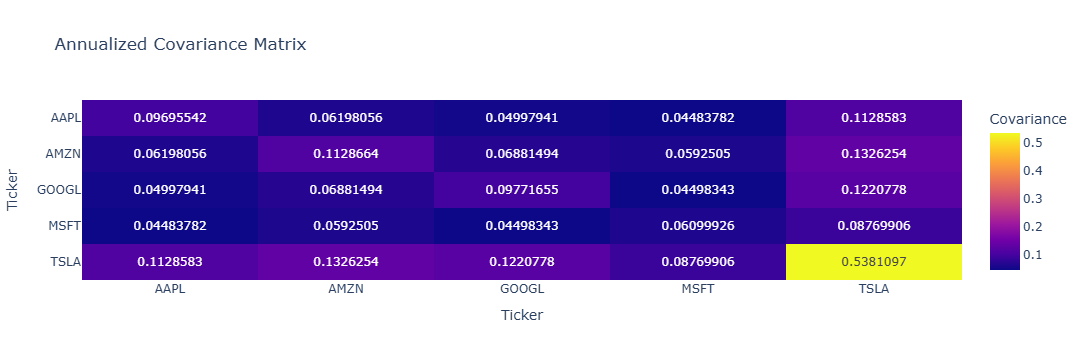

✅ Saved images/covariance.png


In [24]:

# Annualize covariance
cov = returns.cov() * 252

# Plot heat-map
fig_cov = px.imshow(
    cov,
    text_auto=True,
    aspect="auto",
    title="Annualized Covariance Matrix",
    labels=dict(x="Ticker", y="Ticker", color="Covariance")
)

# Save and show
fig_cov.write_image("images/covariance.png", width=600, height=600)
fig_cov.show()
print("✅ Saved images/covariance.png")


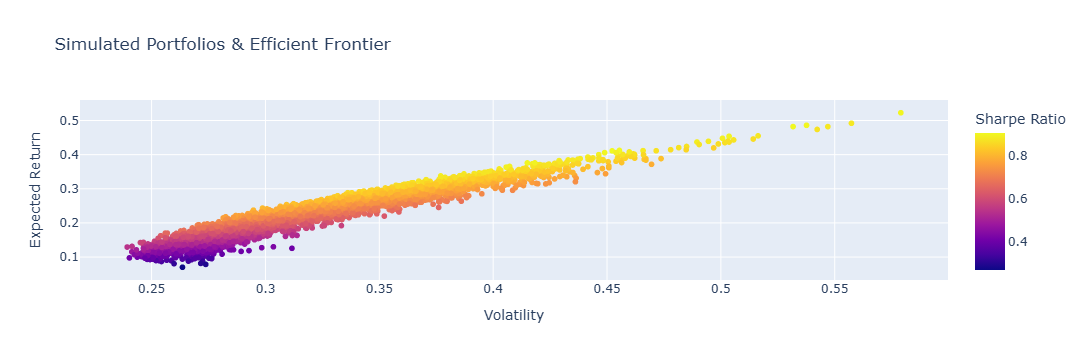

✅ Saved images/efficient_frontier.png


In [26]:

mean_ret = returns.mean() * 252
cov_mat  = returns.cov()  * 252
n_sims   = 5000

# Simulate portfolios
results = np.zeros((3, n_sims))
for i in range(n_sims):
    w = np.random.random(len(vol_pct))
    w /= w.sum()
    port_ret = np.dot(w, mean_ret)
    port_vol = np.sqrt(w.T @ cov_mat @ w)
    results[0,i] = port_vol
    results[1,i] = port_ret
    results[2,i] = port_ret / port_vol  # Sharpe ratio

# DataFrame of simulations
port_df = pd.DataFrame(
    results.T,
    columns=["vol", "ret", "sharpe"]
)

# Plot the efficient frontier
fig_eff = px.scatter(
    port_df,
    x="vol", y="ret", color="sharpe",
    labels={"vol":"Volatility","ret":"Expected Return","sharpe":"Sharpe Ratio"},
    title="Simulated Portfolios & Efficient Frontier"
)

# Save and show
fig_eff.write_image("images/efficient_frontier.png", width=700, height=500)
fig_eff.show()
print("✅ Saved images/efficient_frontier.png")
